# Simple MNIST with PyTorch

Here, I train a single-layer softmax network on the MNIST dataset. At the end, we can visualize the weight matrices that correspond to each digit, to see what the network learned about the pixels that correlate positively vs. negatively with a given classification.

In [1]:
import os
import sys
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [2]:
dir_path = os.path.dirname(os.path.realpath('__file__')) # absolute path of notebook
dataset_path = os.path.join(dir_path, "../data/mnist.pkl.gz")
if not os.path.exists(dataset_path):
    print('Downloading dataset with curl ...')
    if not os.path.exists(os.path.join(dir_path, '../data')):
        os.mkdir(os.path.join(dir_path, '../data'))
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not os.path.exists(dataset_path) else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


In [3]:
dtype = torch.float32
torch.set_default_dtype(dtype)

In [4]:
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, transform=None):
        self.mnist = data
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        sample = self.mnist[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert samples (np.ndarray, np.ndarray) to (torch.tensor, torch.tensor)"""
    def __call__(self, sample):
        image, one_hot_label = sample
        image = torch.from_numpy(image).to(dtype)
        label = torch.tensor(np.argmax(one_hot_label)).to(torch.long)
        return (image, label)


In [5]:
training = MNISTDataset(mnist[:60000], transform=ToTensor())
test = MNISTDataset(mnist[60000:], transform=ToTensor())
training_loader = torch.utils.data.DataLoader(training,
                                        batch_size=10,
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(test,
                                         batch_size=100,
                                         shuffle=True)

In [6]:
class SoftmaxRegression(nn.Module):
    """Single-layer softmax network."""
    def __init__(self, n_in, n_out):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(n_in, n_out)
    
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)
        
model = SoftmaxRegression(28*28, 10)
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
for epoch in range(10):
    for batch in training_loader:
        x, labels = batch       
        output = model(x)
        l = loss(output, labels)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            x, labels = batch
            output = model(x)
            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
    print(" Epoch {} | Accuracy = {:.4f}%".format(epoch, correct / len(test)))

 Epoch 0 | Accuracy = 0.9199%
 Epoch 1 | Accuracy = 0.9231%
 Epoch 2 | Accuracy = 0.9227%
 Epoch 3 | Accuracy = 0.9238%
 Epoch 4 | Accuracy = 0.9276%
 Epoch 5 | Accuracy = 0.9269%
 Epoch 6 | Accuracy = 0.9262%
 Epoch 7 | Accuracy = 0.9260%
 Epoch 8 | Accuracy = 0.9261%
 Epoch 9 | Accuracy = 0.9282%


# Visualize model weights for each digit

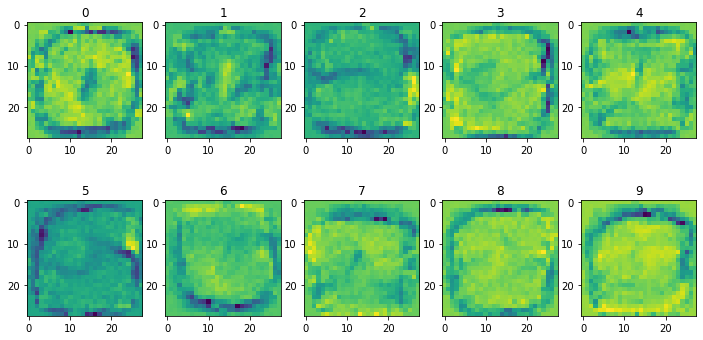

In [8]:
plt.figure(figsize=(12, 6))
with torch.no_grad():
    for i in range(10):
        weights = model.linear.weight[i].reshape(28,28)
        plt.subplot(2, 5, i+1)
        plt.imshow(weights.detach().numpy())
        plt.title(str(i))